# PROJECT STEPS

<li> Data Collection and Problem Statement</li>
<li> Exploratory Data Analysis with Pandas and NumPy</li>
<li> Data Preparation using Sklearn</li>
<li> Selecting and Training a few Machine Learning Models
<li> Cross-Validation and Hyperparameter Tuning using Sklearn</li>
<li> Deploying the Final Trained Model</li>


# Introduction

- In the following midterm project , We will use the [Hotel booking demand data set](https://www.kaggle.com/jessemostipak/hotel-booking-demand) from Kaggle, to predict whenever a customer's booking will be cancelled or not
  .


This data set contains a single file which compares various booking information between two hotels: a resort hotel(H1), and a city hotel(H2) , comprehending bookings due to arrive between July of 2015 and the 31st of August 2017, including bookings that effectively arrived and bookings that were canceled. [Article](https://www.sciencedirect.com/science/article/pii/S2352340918315191)


## Task: Predict the possibility of a booking


In [3]:
# importing necessary modules


import pygal


import numpy as np
import pandas as pd


# graphing libraries
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import graphviz
# importing libraries for xgboost
import xgboost



from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score 


import kaleido # to export map to img


#matplotlib styles
plt.style.use(['ggplot'])
plt.rcParams['axes.grid'] = False


import subprocess

from subprocess import check_output
import gc

%matplotlib inline



## Reading the data set


In [4]:
df = pd.read_csv('input/hotel_bookings.csv')

In [5]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [6]:
# checking amount of rows and columns

df.shape

(119390, 32)

## Exploratory Data Analysis with Pandas and NumPy


In [7]:
# checking data types

df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [8]:
df.nunique()  # checking unique values


hotel                                2
is_canceled                          2
lead_time                          479
arrival_date_year                    3
arrival_date_month                  12
arrival_date_week_number            53
arrival_date_day_of_month           31
stays_in_weekend_nights             17
stays_in_week_nights                35
adults                              14
children                             5
babies                               5
meal                                 5
country                            177
market_segment                       8
distribution_channel                 5
is_repeated_guest                    2
previous_cancellations              15
previous_bookings_not_canceled      73
reserved_room_type                  10
assigned_room_type                  12
booking_changes                     21
deposit_type                         3
agent                              333
company                            352
days_in_waiting_list     

In [9]:
df.isnull().sum()  # Null values


hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

We can see that the features that present the more amount of NULL values are:

- Company:ID of the company/entity that made the booking or responsible for paying the booking. ID is presented instead of designation for anonymity reasons

- Agent:ID of the travel agency that made the booking

- Country:Country of origin. Categories are represented in the ISO 3155–3:2013 format


From the article , the `NULL` values present in the categorical variables of `company` and `agent` should not be considered as missing , rather as "not applicable" meaning that the customer did not come with a traveling agent or company. So we leave them untouched


Answering a few questions with EDA:

- Where do the guests come from? (Country of H1 and H2)
- How much guests come in each month ?
- How likely is for a repeated and non repeated guest to cancel a booking
- Main customers type
- Days in waiting list vs cancellation
- Previous cancellations
- What kind of Market(Type of customer ) is more likely to cancel a booking?


1. Mapping Guests


In [10]:
from collections import Counter

count = Counter(df.country)

In [11]:
count

Counter({'PRT': 48590,
         'GBR': 12129,
         'USA': 2097,
         'ESP': 8568,
         'IRL': 3375,
         'FRA': 10415,
         nan: 488,
         'ROU': 500,
         'NOR': 607,
         'OMN': 18,
         'ARG': 214,
         'POL': 919,
         'DEU': 7287,
         'BEL': 2342,
         'CHE': 1730,
         'CN': 1279,
         'GRC': 128,
         'ITA': 3766,
         'NLD': 2104,
         'DNK': 435,
         'RUS': 632,
         'SWE': 1024,
         'AUS': 426,
         'EST': 83,
         'CZE': 171,
         'BRA': 2224,
         'FIN': 447,
         'MOZ': 67,
         'BWA': 1,
         'LUX': 287,
         'SVN': 57,
         'ALB': 12,
         'IND': 152,
         'CHN': 999,
         'MEX': 85,
         'MAR': 259,
         'UKR': 68,
         'SMR': 1,
         'LVA': 55,
         'PRI': 12,
         'SRB': 101,
         'CHL': 65,
         'AUT': 1263,
         'BLR': 26,
         'LTU': 81,
         'TUR': 248,
         'ZAF': 80,
         'AGO':

In [12]:
df_resort = df.loc[df.hotel == 'Resort Hotel']  # pick members from H1


In [13]:
import matplotlib.image as img


def show_country_map(country):
    
    c = Counter(country)

    country = pd.DataFrame.from_records(list(dict(c).items()),
                                        columns=['country', 'count'])
    total_guests = country["count"].sum()


    country["Guests in %"] = round(country["count"] / total_guests * 100, 2)


    guest_map = px.choropleth(
        country,
        locations=country.country,
        color=country["Guests in %"],
        hover_name=country.country,
        color_continuous_scale=px.colors.sequential.Inferno,
        title="Home country of Guests ")


    guest_map.write_image("img/map.png", width=1280, height=720)

    im = img.imread('img/map.png')
    # show image
    fig = plt.gcf()
    fig.set_size_inches(20, 20)
    plt.imshow(im)


In [14]:
def plot_pie(country):
    c = Counter(country).most_common(10)


    country = pd.DataFrame.from_records(list(dict(c).items()),
                                        columns=['country', 'count'])
    plt.pie(
        country["count"],
        labels=country["country"],
        autopct='%1.1f%%',
        shadow=True,
        startangle=140,
    )

    plt.title("Top 10 Home country of Guests")
    fig = plt.gcf()
    fig.set_size_inches(8, 8)
    plt.show()

In [15]:
df.hotel.value_counts()

City Hotel      79330
Resort Hotel    40060
Name: hotel, dtype: int64

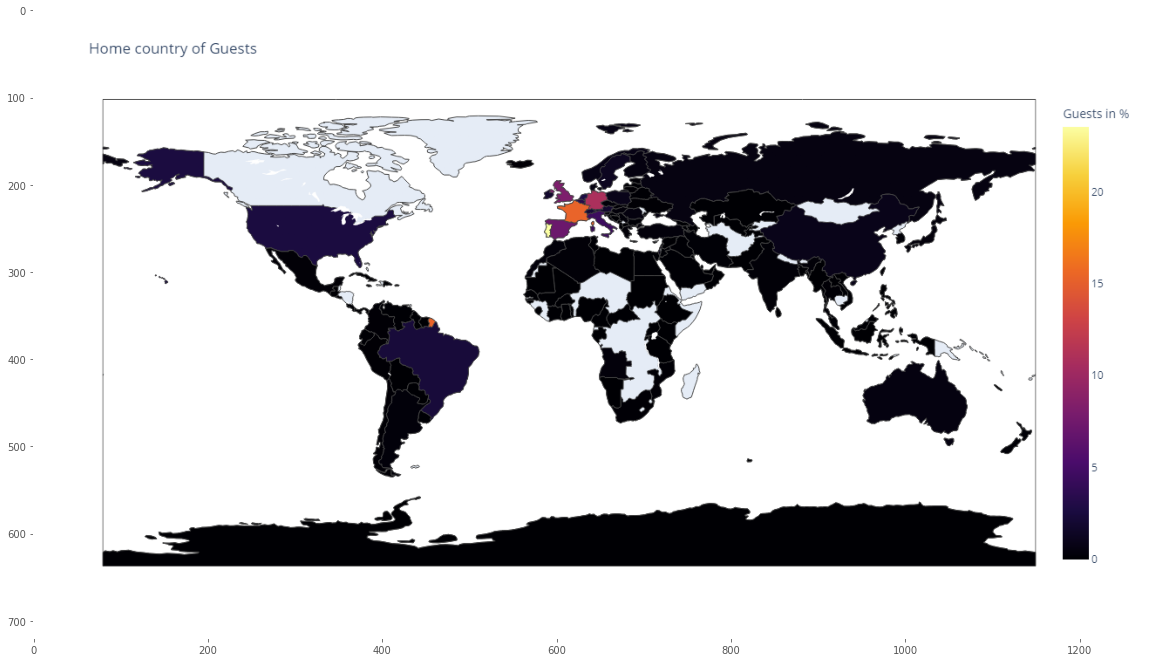

In [16]:
# For H1

df_city = df.loc[df.hotel == 'City Hotel']

show_country_map(df_city.loc[df_city.is_canceled == 0].country)


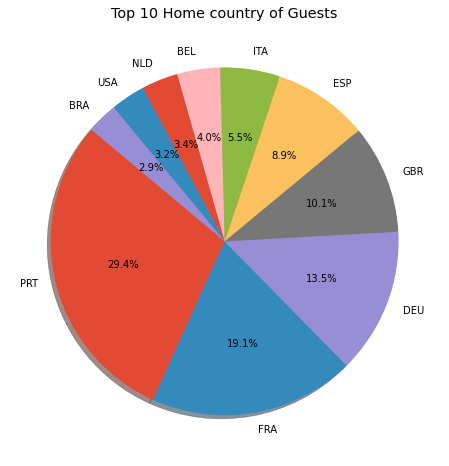

In [17]:
plot_pie(df_city.loc[df_city.is_canceled == 0].country)


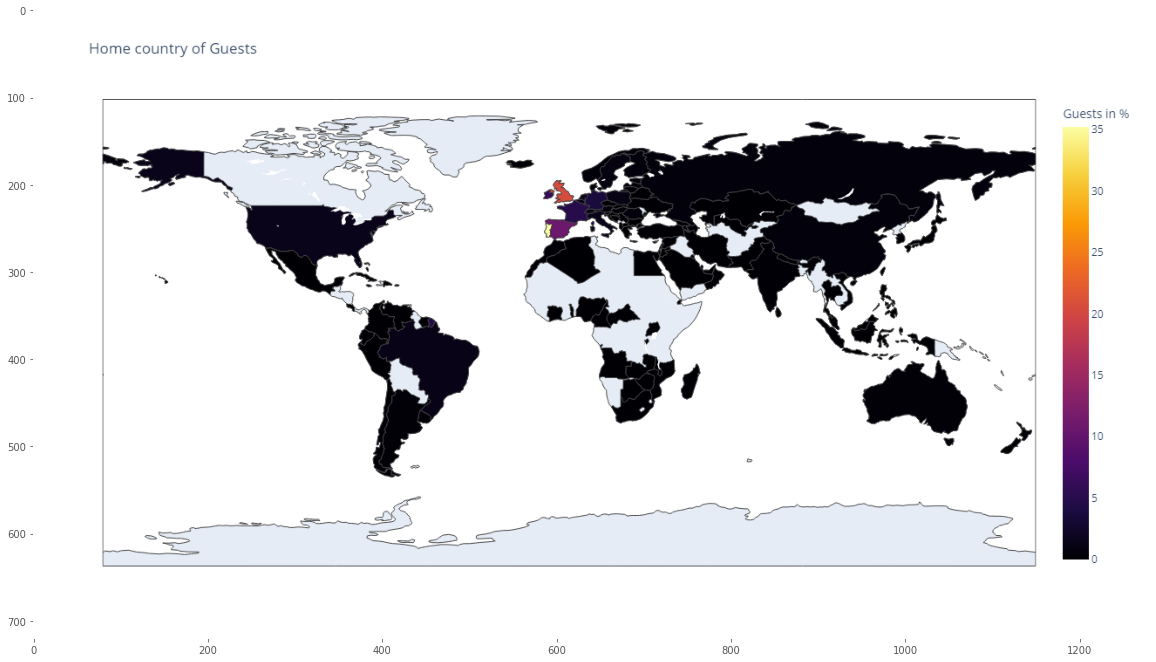

In [18]:
# For H2

df_resort = df.loc[df.hotel == 'Resort Hotel']

show_country_map(df_resort.loc[df_resort.is_canceled == 0].country)


# Cancellations by country

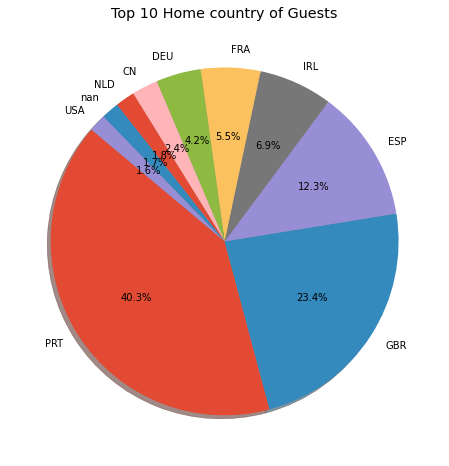

In [19]:
# plot top 10 country of guests
plot_pie(df_resort.loc[df_resort.is_canceled == 0].country)


## Cancellations for each hotel type


<AxesSubplot:title={'center':'For city hotel'}, ylabel='is_canceled'>

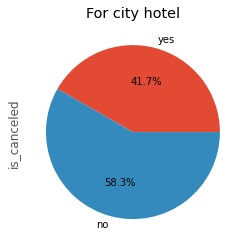

In [20]:
labels = 'yes', 'no'

df_city.is_canceled.value_counts().sort_values().plot.pie(
    labels=labels, autopct='%1.1f%%', title='For city hotel')


<AxesSubplot:title={'center':'For resort Hotel'}, ylabel='is_canceled'>

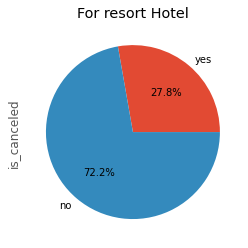

In [21]:
df_resort.is_canceled.value_counts().sort_values().plot.pie(
    labels=labels, autopct='%1.1f%%', title='For resort Hotel')


## How much guests come each month ?


<AxesSubplot:>

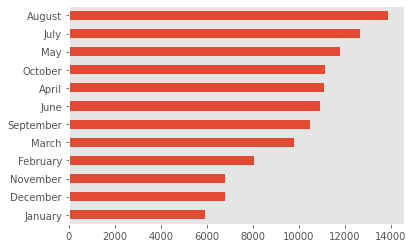

In [22]:
df.arrival_date_month.value_counts().sort_values().plot.barh()


<AxesSubplot:>

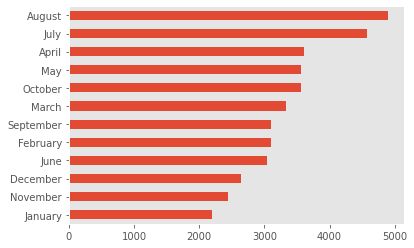

In [23]:
df_resort.arrival_date_month.value_counts().sort_values().plot.barh()


`August` and `July` seem to be the busiest month across the board on both hotels.

## How likely is for a repeating customer to cancel a booking


In [24]:
df_repeating = df.loc[df.is_repeated_guest == 1]
df_non_repeating = df.loc[df.is_repeated_guest == 0]

Text(0.5, 1.0, 'Returning Customers canceling bookings ')

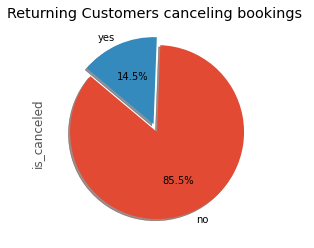

In [25]:
labels = ['no', 'yes']
# explode 2nd slice
explode = (0, 0.1)

df_repeating.is_canceled.value_counts().plot(kind='pie',
                                             labels=labels,
                                             autopct='%1.1f%%',
                                             shadow=True,
                                             startangle=140,
                                             explode=explode)
plt.title("Returning Customers canceling bookings ")


Text(0.5, 1.0, 'Non Returning Customers canceling bookings ')

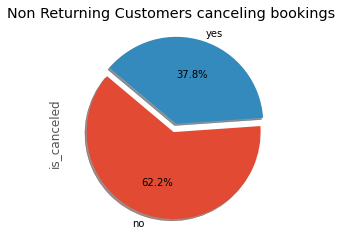

In [26]:
labels = ['no', 'yes']
# explode 2nd slice
explode = (0, 0.1)

df_non_repeating.is_canceled.value_counts().plot(kind='pie',
                                                 labels=labels,
                                                 autopct='%1.1f%%',
                                                 shadow=True,
                                                 startangle=140,
                                                 explode=explode)
plt.title("Non Returning Customers canceling bookings ")

We can see a slight variation comparing returning customers to non returning customers, with the latter being more likely to cancel a booking.


# Feature Selection


## Mutual Information


In [27]:
# filling missing values
df['country'] = df['country'].fillna('NA')
df['children'] = df['children'].fillna(0)

# filling with 0 and converting to int

df['agent'] = df['agent'].fillna(0).astype(int)  
df['company'] = df['company'].fillna(0).astype(int)


In [28]:
# creating numerical and categorial variables
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numerical = df.select_dtypes(include=numerics).columns.tolist()

category = ['object']

categorical = df.select_dtypes(include=category).columns.tolist()

In [29]:
print("Initial categorical Features:",categorical)


Initial categorical Features: ['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status', 'reservation_status_date']


In [30]:

print("Initial numerical Features:" ,numerical)

Initial numerical Features: ['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'agent', 'company', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']


<AxesSubplot:ylabel='customer_type'>

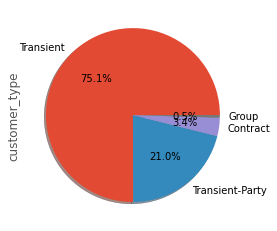

In [31]:
# Main type of customers
df.customer_type.value_counts().plot(kind="pie",
                                     autopct='%1.1f%%',
                                     shadow=True)


We can see that Transient represents the majority of customers, that is , customers that are not part of any group or contract


We will calculate the mutual information between the variables X (categorical ) and target y.


In [32]:
def mutual_info_categorical(series):
    return mutual_info_score(series, df.is_canceled)

<AxesSubplot:>

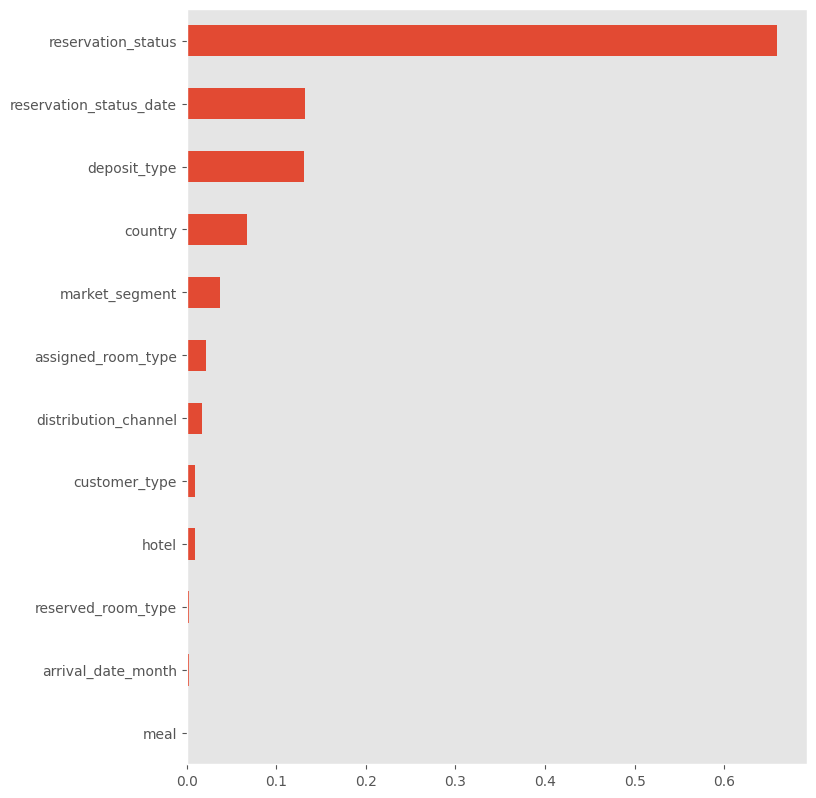

In [33]:
from matplotlib.pyplot import figure
from sklearn.metrics import mutual_info_score

mi = df[categorical].apply(mutual_info_categorical)
figure(figsize=(8, 10), dpi=100)
mi.sort_values(ascending=True).plot(kind='barh')


We can see that the 3 most important features are `reservation_status` , `reservation_status_date` and `deposit_type`


However ,to avoid over-fitting and data leakage , it would be better to drop the `reservation_status` variable


---


## Reservation Status vs Actual cancellations


Reservation_status : Reservation last status, assuming one of three categories: Canceled – booking was canceled by the customer; Check-Out – customer has checked in but already departed; No-Show – customer did not check-in and did inform the hotel of the reason why


In [34]:
df.reservation_status.value_counts()

Check-Out    75166
Canceled     43017
No-Show       1207
Name: reservation_status, dtype: int64

In [35]:
df.is_canceled.value_counts()

0    75166
1    44224
Name: is_canceled, dtype: int64

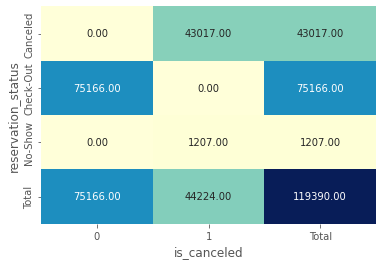

In [36]:
tab = pd.crosstab(columns=df['reservation_status'],
                  index=df['is_canceled'],
                  margins=True,
                  margins_name='Total')

res = sns.heatmap(tab.T, annot=True, fmt='.2f', cmap="YlGnBu", cbar=False)

plt.savefig("img/crosstab_pandas.png", bbox_inches='tight', dpi=100)

plt.show()

We can clearly see how this variable is affecting the result and may cause data leakage, so we will exclude it along with `reservation_status_date`


In [37]:
#df = df.drop(['reservation_status', 'reservation_status_date'], axis=1)


In [38]:
categorical.remove('reservation_status')
categorical.remove('reservation_status_date')

<AxesSubplot:>

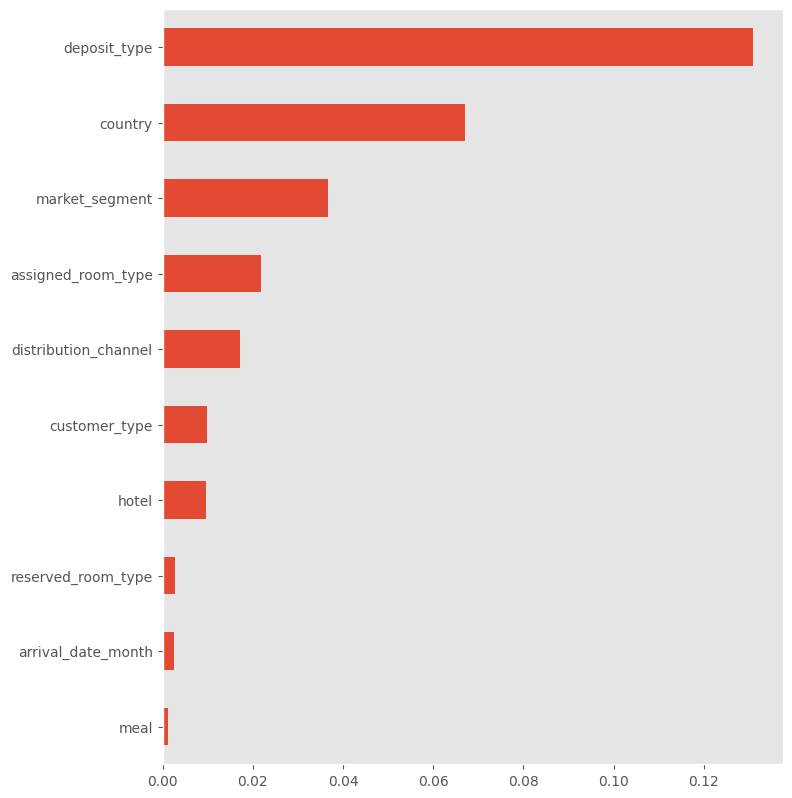

In [39]:
from matplotlib.pyplot import figure
from sklearn.metrics import mutual_info_score

mi = df[categorical].apply(mutual_info_categorical)
figure(figsize=(8, 10), dpi=100)
mi.sort_values(ascending=True).plot(kind='barh')


In [40]:
mi.sort_values(ascending=False)

deposit_type            0.130952
country                 0.067132
market_segment          0.036687
assigned_room_type      0.021782
distribution_channel    0.017106
customer_type           0.009796
hotel                   0.009541
reserved_room_type      0.002776
arrival_date_month      0.002489
meal                    0.001264
dtype: float64

We also want to make our model to be as <i> general </i> as possible, as well as preventing the model to be biased towards determined countries , so we will exclude `country` . Furthermore, according to the article , it is also possible that the hotel may not know the correct nationality of the customer until the catual moment of check-in.

In [41]:
categorical.remove('country')

# Pearson Correlation


- Checking correlation between variables so we can know what variables we can drop , to avoid over fitting


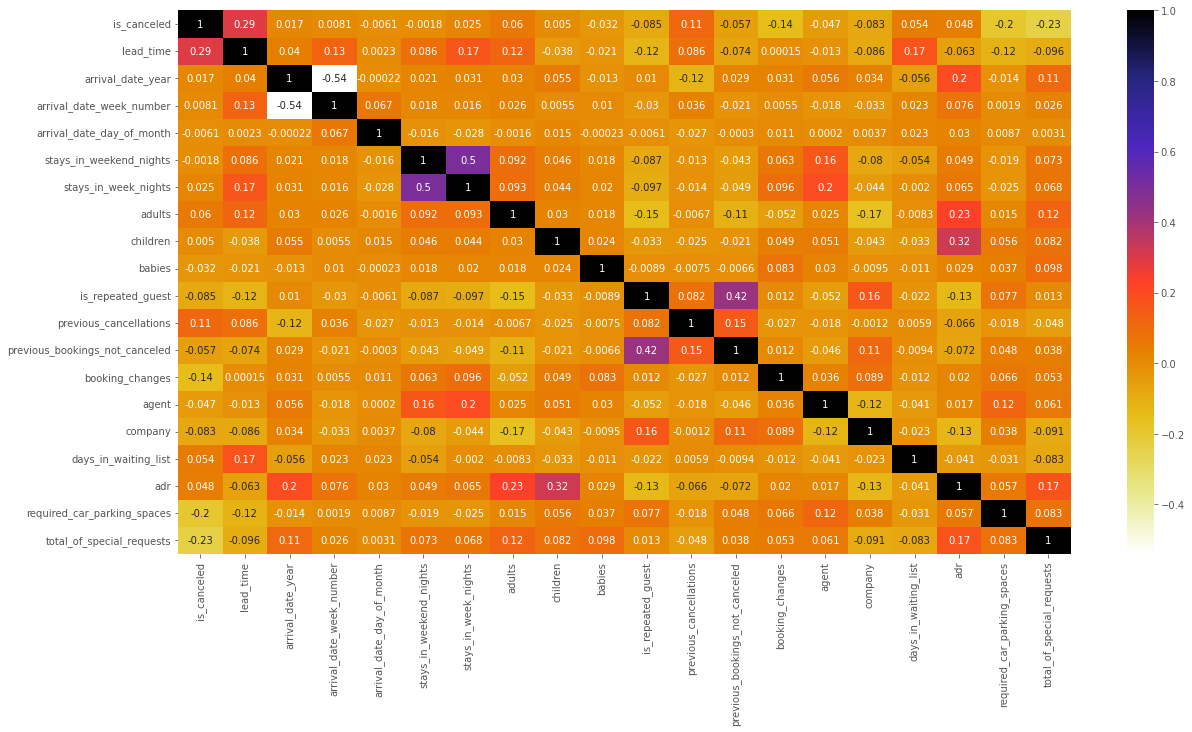

In [42]:
import seaborn as sns
# Using pearson correlation
plt.figure(figsize=(20, 10))
corr = df[numerical].corr(method='pearson')
sns.heatmap(corr, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

Arrival date_week_number  has barely any impact on the target variable $(0.008)$ , so we will remove it

<AxesSubplot:ylabel='customer_type'>

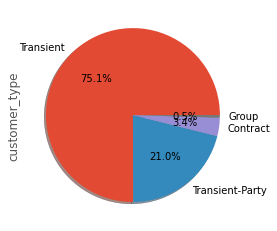

In [43]:
# Main type of customers
df.customer_type.value_counts().plot(kind="pie",
                                     autopct='%1.1f%%',
                                     shadow=True)


In [44]:
# import calendar
# df.arrival_date_year = df.arrival_date_year.map(str)
# df.arrival_date_day_of_month = df.arrival_date_day_of_month.map(str) # to string
# df['arrival_date_month'] = df['arrival_date_month'].str[0:3]
# df['arrival_date_month'] = df['arrival_date_month'].apply(lambda x: list(calendar.month_abbr).index(x)) # converting months to month numbers
# df['arrival_date_month'] = df['arrival_date_month'].map(str)

# df['arrival_date'] = df[['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month']].agg('-'.join, axis=1)

# df['arrival_date'] = pd.to_datetime(df['arrival_date'],
#  format = '%Y-%m-%d',
#  errors = 'coerce')

# df = df.drop(df[['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month']], 1)

# <b> Categorical Variables: </b>

## Deposit_type 

Deposit type indicates whenever a customer made a deposit to guarantee their booking , we will examine this feature in further detail.

In [45]:
from numpy import mean

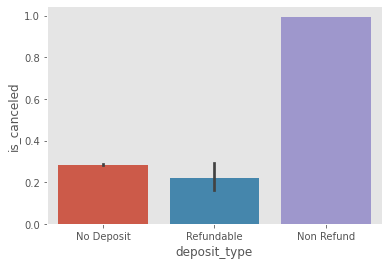

In [46]:
deposit_plot = sns.barplot(x="deposit_type",y="is_canceled",data=df,estimator=mean)

We can see an overwhelming majority of people that choose `non refund` decided to cancel their booking , however we may check that this type of variable does not represent the majority of customers, lets see.

In [47]:
groups = df.groupby('deposit_type')['is_canceled'].count()
groups

deposit_type
No Deposit    104641
Non Refund     14587
Refundable       162
Name: is_canceled, dtype: int64

In [48]:
df.groupby('deposit_type')['is_canceled'].mean()

deposit_type
No Deposit    0.283770
Non Refund    0.993624
Refundable    0.222222
Name: is_canceled, dtype: float64

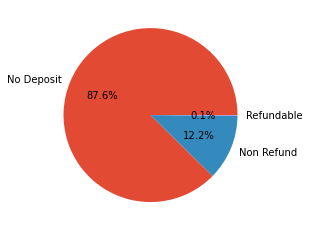

In [49]:
labels=['No Deposit','Non Refund','Refundable']

plt.pie(x=groups,autopct='%1.1f%%',labels=labels);

 `Non refund` customers barely represents 12.2% of the actual data , furthermore ,`Non refund` has a very high value of canceled ratio (almost $100\%$) but its volume is way less compared to the other type of deposits,so, to avoid making wrong assumptions  we will drop this one as well.

In [50]:
categorical.remove('deposit_type')

## Customer_type counts and actual cancellations  

In [51]:
customer = df.groupby('customer_type')['is_canceled'].count()
customer

customer_type
Contract            4076
Group                577
Transient          89613
Transient-Party    25124
Name: is_canceled, dtype: int64

<AxesSubplot:xlabel='customer_type', ylabel='is_canceled'>

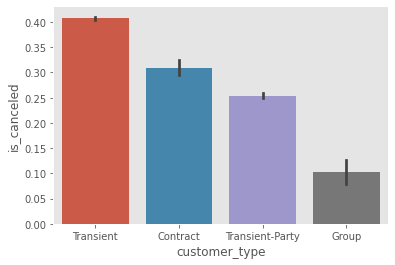

In [52]:
sns.barplot(x="customer_type",y="is_canceled",data=df,estimator=mean)

Transient has enough volume of data, so this feature should be included .

## Reserved Room Type

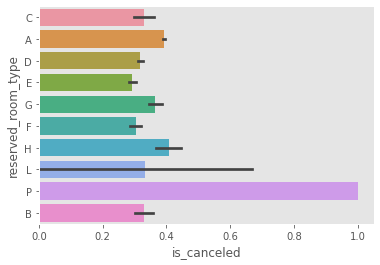

In [53]:
reserved = sns.barplot(y='reserved_room_type',x='is_canceled',data=df,estimator=mean,)

In [54]:
df.groupby('reserved_room_type')['is_canceled'].mean()

reserved_room_type
A    0.391074
B    0.329159
C    0.330472
D    0.317796
E    0.292884
F    0.303763
G    0.364374
H    0.407654
L    0.333333
P    1.000000
Name: is_canceled, dtype: float64

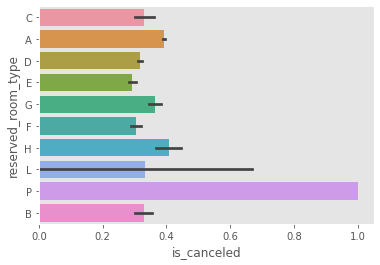

In [55]:
reserved = sns.barplot(y='reserved_room_type',x='is_canceled',data=df,estimator=mean,)

$100 \%$ of people that chose `reserved_room_type` "P" canceled the booking , however , it will be good to verify what amount of the population this group represents.

In [56]:
df['reserved_room_type'].value_counts(normalize=True)* 100

A    72.027808
D    16.082586
E     5.473658
F     2.426501
G     1.753916
B     0.936427
C     0.780635
H     0.503392
P     0.010051
L     0.005026
Name: reserved_room_type, dtype: float64

`reserved_room_type` P represents a measly 0.01 percent of the entire customers but has a  really high cancellation rate , we also see that other rooms are very close to one another in respect to cancellations , we should exclude this feature , given that P has not enough volume of data to back itself up

In [57]:
categorical.remove('reserved_room_type')

## Assigned_room_type

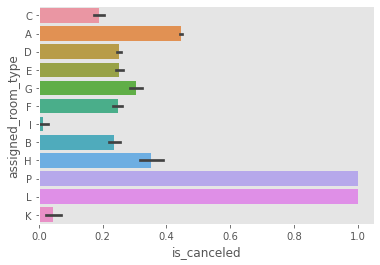

In [58]:
assigned  = sns.barplot(y='assigned_room_type', x='is_canceled',data=df,estimator=mean)

In [59]:
df.groupby('assigned_room_type')['is_canceled'].mean()

assigned_room_type
A    0.444925
B    0.236708
C    0.187789
D    0.251244
E    0.252114
F    0.247134
G    0.305523
H    0.352528
I    0.013774
K    0.043011
L    1.000000
P    1.000000
Name: is_canceled, dtype: float64

In [60]:
df['assigned_room_type'].value_counts(normalize=True)* 100

A    62.026133
D    21.209482
E     6.538236
F     3.141804
G     2.138370
C     1.989279
B     1.811710
H     0.596365
I     0.304046
K     0.233688
P     0.010051
L     0.000838
Name: assigned_room_type, dtype: float64

We can see the exact same deal happens with the assigned_room_type , where L and P have a astonishingly high cancellation but barely any data to back it up, so it should also be excluded .

In [61]:
categorical.remove('assigned_room_type')

## <b> Numerical  </b>


### Lead_time :Number of days that elapsed between the entering date of the booking into the PMS and the arrival date

In [62]:
df['lead_time'].value_counts()

0      6345
1      3460
2      2069
3      1816
4      1715
       ... 
400       1
370       1
532       1
371       1
463       1
Name: lead_time, Length: 479, dtype: int64

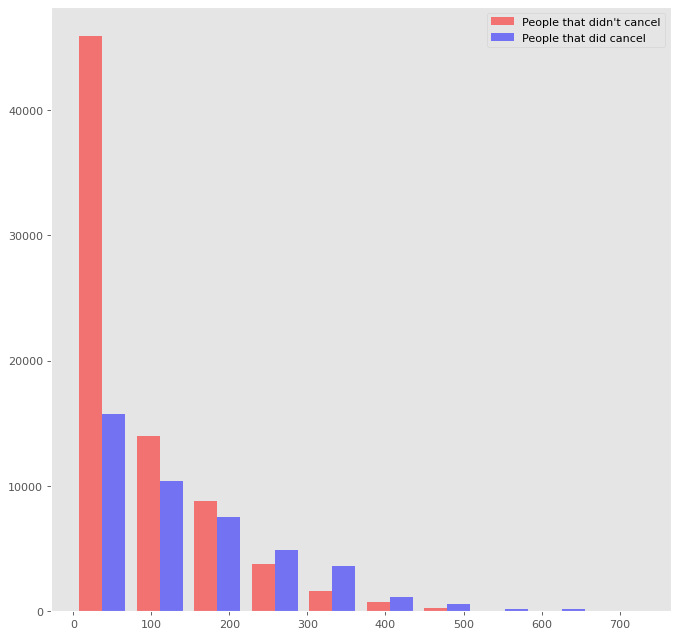

In [63]:
figure(figsize=(10, 10), dpi=80)


x= df.loc[df["is_canceled"]==0]['lead_time']
y=df.loc[df["is_canceled"]==1]['lead_time']

labels= ["People that didn't cancel",'People that did cancel']


plt.hist([x, y], color=['r','b'], alpha=0.5);
plt.legend(labels=labels);


We see a  variation in the graph, there is a high disproportion of values for  People that didn't cancel and people who did between the range of 0 to 100 days, but after that it gets a bit more even, until 200+ days where people that cancelled take the lead .

##  Removing the target variable from numerical

In [64]:
numerical.remove('is_canceled')

## Final features to include 

In [65]:
display(categorical)

['hotel',
 'arrival_date_month',
 'meal',
 'market_segment',
 'distribution_channel',
 'customer_type']

In [66]:
display(numerical)

['lead_time',
 'arrival_date_year',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent',
 'company',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests']

# Setting up validation framework


In [67]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2,random_state=0)
df_train, df_val = train_test_split(df_full_train, test_size=0.25,random_state=0)


In [68]:
len(df_train), len(df_val), len(df_test)


(71634, 23878, 23878)

In [69]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.is_canceled.values
y_val = df_val.is_canceled.values
y_test = df_test.is_canceled.values


In [70]:

del df_train['is_canceled']
del df_val['is_canceled']
del df_test['is_canceled']


## Feature selection | Feature Importance


What features to delete ?


In [71]:
df_full_train = df_full_train.reset_index(drop=True)


<AxesSubplot:ylabel='is_canceled'>

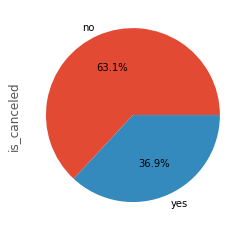

In [72]:
labels = "no", "yes"
df_full_train.is_canceled.value_counts(normalize=True).plot(kind="pie",
                                                            autopct='%1.1f%%',
                                                            labels=labels)


In [73]:
df[categorical].dtypes

hotel                   object
arrival_date_month      object
meal                    object
market_segment          object
distribution_channel    object
customer_type           object
dtype: object

## Numerical features


<AxesSubplot:>

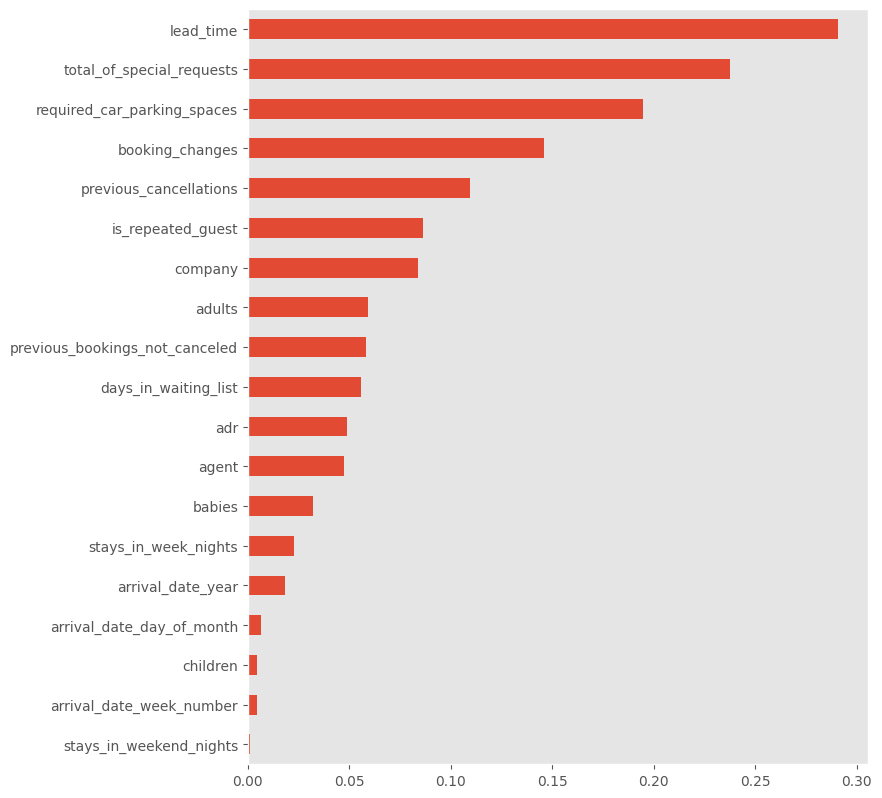

In [74]:
correlation = df_full_train.corr()['is_canceled'].abs().sort_values(
    ascending=True)
figure(figsize=(8, 10), dpi=100)
correlation.iloc[:-1].plot(kind='barh')


We get that the most important features are `lead_time`(Number of days elapsed between entering day of the booking and arrival ), `total_of_special_requests` ,`agent` and `required_car_parking_spaces`


# One hot encoding


In [75]:
df_full_train[categorical].head()

,hotel,arrival_date_month,meal,market_segment,distribution_channel,customer_type
0,City Hotel,August,BB,Online TA,TA/TO,Transient
1,City Hotel,August,BB,Online TA,TA/TO,Transient
2,City Hotel,September,BB,Online TA,TA/TO,Transient
3,City Hotel,March,BB,Online TA,TA/TO,Transient
4,City Hotel,April,HB,Direct,Direct,Transient


In [76]:
# Using sklearn to encode the categorical features

from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)




train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [77]:
dv.get_feature_names()


['adr',
 'adults',
 'agent',
 'arrival_date_day_of_month',
 'arrival_date_month=April',
 'arrival_date_month=August',
 'arrival_date_month=December',
 'arrival_date_month=February',
 'arrival_date_month=January',
 'arrival_date_month=July',
 'arrival_date_month=June',
 'arrival_date_month=March',
 'arrival_date_month=May',
 'arrival_date_month=November',
 'arrival_date_month=October',
 'arrival_date_month=September',
 'arrival_date_week_number',
 'arrival_date_year',
 'babies',
 'booking_changes',
 'children',
 'company',
 'customer_type=Contract',
 'customer_type=Group',
 'customer_type=Transient',
 'customer_type=Transient-Party',
 'days_in_waiting_list',
 'distribution_channel=Corporate',
 'distribution_channel=Direct',
 'distribution_channel=GDS',
 'distribution_channel=TA/TO',
 'distribution_channel=Undefined',
 'hotel=City Hotel',
 'hotel=Resort Hotel',
 'is_repeated_guest',
 'lead_time',
 'market_segment=Aviation',
 'market_segment=Complementary',
 'market_segment=Corporate',
 '

In [78]:
dicts_test = df_test[categorical + numerical].to_dict(orient='records')


In [79]:
X_test = dv.transform(dicts_test)


# Training logistic regression with Scikit-Learn


In [80]:
from sklearn.linear_model import LogisticRegression


In [81]:
classifier = LogisticRegression(random_state=0, max_iter=1000)
classifier.fit(X_train, y_train)

C:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(max_iter=1000, random_state=0)

In [82]:
y_pred_lr = classifier.predict(X_test)


In [83]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_lr)
cm


array([[13385,  1549],
       [ 3745,  5199]], dtype=int64)

In [84]:
from sklearn.metrics import accuracy_score

lr_score = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy Score of Logistic Regression: {lr_score}")


Accuracy Score of Logistic Regression: 0.7782896389982411


Checking the Precision and recall value


In [85]:
clf_report = classification_report(y_test, y_pred_lr)
print(f"Classification Report : \n{clf_report}")


Classification Report : 
              precision    recall  f1-score   support

           0       0.78      0.90      0.83     14934
           1       0.77      0.58      0.66      8944

    accuracy                           0.78     23878
   macro avg       0.78      0.74      0.75     23878
weighted avg       0.78      0.78      0.77     23878



## AUC Curve of Logistic Regression


In [86]:
from sklearn import metrics


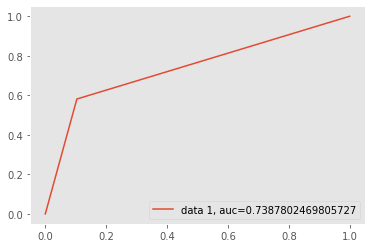

In [87]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_lr)
auc = metrics.roc_auc_score(y_test, y_pred_lr)
plt.plot(fpr, tpr, label="data 1, auc=" + str(auc))
plt.legend(loc=4)
plt.show()


## Test 1 customer


In [88]:
customer = dicts_test[-40]


In [89]:
customer

{'hotel': 'City Hotel',
 'arrival_date_month': 'January',
 'meal': 'BB',
 'market_segment': 'Groups',
 'distribution_channel': 'TA/TO',
 'customer_type': 'Transient',
 'lead_time': 86,
 'arrival_date_year': 2016,
 'arrival_date_week_number': 4,
 'arrival_date_day_of_month': 22,
 'stays_in_weekend_nights': 0,
 'stays_in_week_nights': 1,
 'adults': 2,
 'children': 0.0,
 'babies': 0,
 'is_repeated_guest': 0,
 'previous_cancellations': 1,
 'previous_bookings_not_canceled': 0,
 'booking_changes': 0,
 'agent': 29,
 'company': 0,
 'days_in_waiting_list': 35,
 'adr': 85.0,
 'required_car_parking_spaces': 0,
 'total_of_special_requests': 0}

In [90]:
X_small = dv.transform([customer])
classifier.predict_proba(X_small)[0, 1]


0.9444180112730746

In [91]:
y_test[-40]


1

# Decision tree classifier


In [92]:
from sklearn import tree

In [93]:
dtc = tree.DecisionTreeClassifier()
dtc.fit(X_train, y_train)
print(dtc.get_params())  # default parameters of decision tree classifier


{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


In [94]:
y_pred_dtc = dtc.predict(X_test)

acc_dtc = accuracy_score(y_test, y_pred_dtc)
print(f"Accuracy Score of Decision Tree (test dataset) is : {acc_dtc}")


Accuracy Score of Decision Tree (test dataset) is : 0.8243571488399364


In [95]:
y_pred_dtc = dtc.predict(X_val)

acc_dtc = accuracy_score(y_val, y_pred_dtc)
print(f"Accuracy Score of Decision Tree (validation dataset) is : {acc_dtc}")

Accuracy Score of Decision Tree (validation dataset) is : 0.8174889019180835


In [96]:
import graphviz

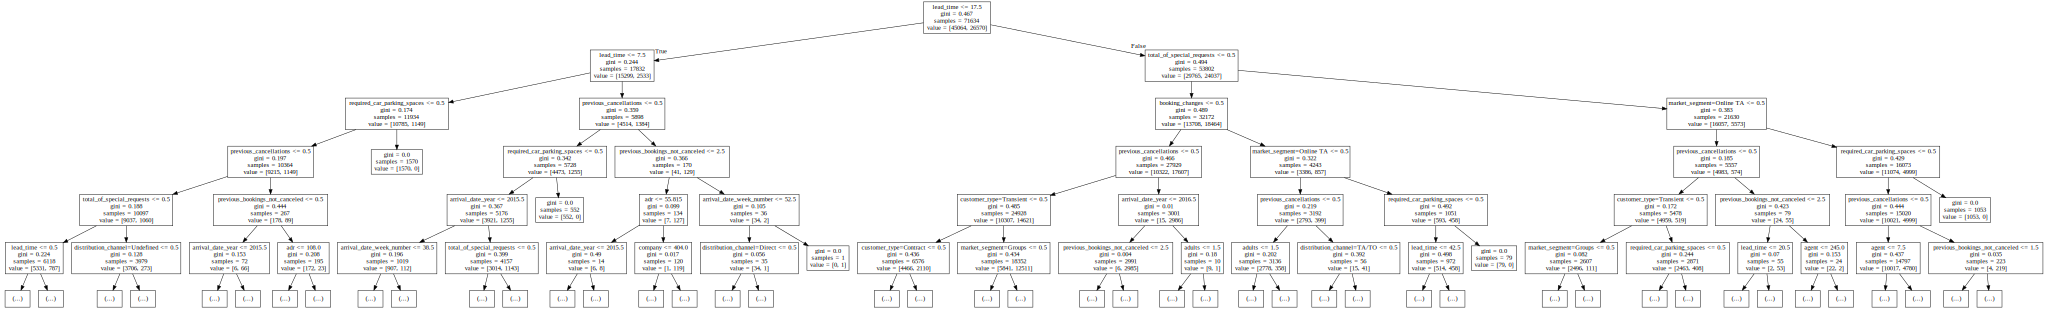

In [97]:
display(
    graphviz.Source(
        tree.export_graphviz(dtc,
                             feature_names=dv.get_feature_names(),
                             max_depth=5)), )


## Parameter tunning of Decision Tree


In [98]:
# selecting a max_depth

numbers = [1, 2, 3, 4, 5, 6, 10, 15, 20, 30, None]

for d in numbers:
    dtc = tree.DecisionTreeClassifier(max_depth=d)

    dtc.fit(X_train, y_train)

    y_pred_dtc = dtc.predict(X_test)

    auc = accuracy_score(y_test, y_pred_dtc)

    print(" %4s -> %.3f " % (d, auc))


    1 -> 0.625 
    2 -> 0.693 
    3 -> 0.729 
    4 -> 0.730 
    5 -> 0.769 
    6 -> 0.770 
   10 -> 0.808 
   15 -> 0.825 
   20 -> 0.827 
   30 -> 0.825 
 None -> 0.823 


Growth seem to stop around max_depth [10,20]


In [99]:
# Now lets test the scores changing the amount of leafs

scores = []

for depth in [10, 15, 20]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:

        dt = tree.DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)

        dt.fit(X_train, y_train)

        y_pred_dtc = dt.predict(X_test)

        auc = accuracy_score(y_test, y_pred_dtc)

        scores.append((depth, s, auc))


<AxesSubplot:xlabel='None-max_depth', ylabel='min_samples_leaf'>

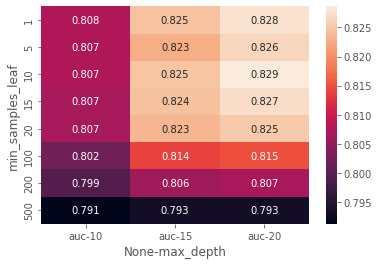

In [100]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores_pivot = df_scores.pivot(index='min_samples_leaf',
                                  columns=['max_depth'],
                                  values=['auc'])
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")


The best score seems to be at min_samples_leaf = 1 and max_depth of 20


In [101]:
dtc = tree.DecisionTreeClassifier(max_depth=20, min_samples_leaf=1)
dtc.fit(X_train, y_train)

y_pred_dtc = dtc.predict(X_test)

acc_dtc = accuracy_score(y_test, y_pred_dtc)
print(f"Accuracy Score of Decision Tree (test dataset) is : {acc_dtc}")

Accuracy Score of Decision Tree (test dataset) is : 0.8265348856688165


In [102]:
dtc = tree.DecisionTreeClassifier(max_depth=15, min_samples_leaf=1)
dtc.fit(X_train, y_train)

y_pred_dtc = dtc.predict(X_val)

acc_dtc = accuracy_score(y_val, y_pred_dtc)
print(f"Accuracy Score of Decision Tree (Validation dataset) is : {acc_dtc}")

Accuracy Score of Decision Tree (Validation dataset) is : 0.8238127146327163


# Random Forest


In [103]:
from sklearn.ensemble import RandomForestClassifier

Rf_model = RandomForestClassifier(n_estimators=20)
Rf_model.fit(X_train, y_train)
display(Rf_model.get_params())  # default_parameters of the random forest model


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 20,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [104]:
y_pred_dtc = Rf_model.predict(X_val)

acc_dtc = accuracy_score(y_val, y_pred_dtc)
print(
    f"Accuracy Score of Random Forest Classifier (Validation dataset) is : {acc_dtc}. \n"
)

print("------------ Confussion Matrix --------------- \n")
print(confusion_matrix(y_test, y_pred_dtc))

roc_rf = roc_auc_score(y_val, y_pred_dtc)
print(f"Roc auc score : {roc_rf}")

Accuracy Score of Random Forest Classifier (Validation dataset) is : 0.8588240221124047. 

------------ Confussion Matrix --------------- 

[[10140  4794]
 [ 6059  2885]]
Roc auc score : 0.8350829379150984


Let's now do parameter tunning of the random forest model


In [105]:
print(f'Train Accuracy - : {Rf_model.score(X_train,y_train):.3f}')
print(f'Test Accuracy - : {Rf_model.score(X_test,y_test):.3f}')


Train Accuracy - : 0.989
Test Accuracy - : 0.862


The score for train is quite big , it may be overfitting


### Feature Importance within the Random Forest


In [106]:
importances = Rf_model.feature_importances_

#create a feature list from the original dataset (list of columns)
# What are this numbers? Let's get back to the columns of the original dataset
feature_list = list(df_train.columns)

#create a list of tuples
feature_importance = sorted(zip(importances, feature_list), reverse=True)

#create two lists from the previous list of tuples
df_imp = pd.DataFrame(feature_importance, columns=['importance', 'feature'])
importance = list(df_imp['importance'])
feature = list(df_imp['feature'])

#see df
print(df_imp)


    importance                         feature
0     0.105740                           hotel
1     0.070822              arrival_date_month
2     0.057460          previous_cancellations
3     0.055664               arrival_date_year
4     0.028342            days_in_waiting_list
5     0.024775              assigned_room_type
6     0.021601  previous_bookings_not_canceled
7     0.021480                   customer_type
8     0.018791                       lead_time
9     0.010846         reservation_status_date
10    0.008712       total_of_special_requests
11    0.008589                 booking_changes
12    0.007276                             adr
13    0.005701                    deposit_type
14    0.005674       arrival_date_day_of_month
15    0.005476                        children
16    0.005199                          babies
17    0.005139                         country
18    0.004806        arrival_date_week_number
19    0.004406               is_repeated_guest
20    0.00432

## Parameter tunning of Random Forest | Grid SearchCV


- n_estimators = number of trees in the foreset
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is - split
- min_samples_leaf = min number of data points allowed in a leaf node
- bootstrap = method for sampling data points (with or without replacement)


In [107]:
from sklearn.model_selection import GridSearchCV


In [108]:
param_grid = {
    "max_depth": [10, 13],
    "n_estimators": [10, 100],
    "min_samples_split": [2, 5]
}


In [109]:
display(param_grid)

{'max_depth': [10, 13], 'n_estimators': [10, 100], 'min_samples_split': [2, 5]}

---

**NOTE**

(This may take a while)

---


In [110]:
rf = RandomForestClassifier()

rf_grid = GridSearchCV(estimator=rf,
                       param_grid=param_grid,
                       cv=10,
                       verbose=2,
                       n_jobs=-1)
#cv reduces chances of over_fitting

rf_grid.fit(X_train, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 13], 'min_samples_split': [2, 5],
                         'n_estimators': [10, 100]},
             verbose=2)

In [111]:
rf_grid.best_params_

{'max_depth': 13, 'min_samples_split': 2, 'n_estimators': 100}

{'max_depth': 13, 'min_samples_split': 2, 'n_estimators': 100}


In [112]:
print(f'Train Accuracy - : {rf_grid.score(X_train,y_train):.3f}')
print(f'Test Accuracy - : {rf_grid.score(X_test,y_test):.3f}')
print(f'Val Accuracy - : {rf_grid.score(X_val,y_val):.3f}')


Train Accuracy - : 0.837
Test Accuracy - : 0.830
Val Accuracy - : 0.830


With these parameters the difference is not that significant


# XGBoost using Scikit-Learn API


In [137]:
xgb_params = {
            'learning_rate': 0.1,  # also called eta
            'max_depth':5,
            'n_estimators':5000, # max_amount of trees
            'subsample':0.5, #
            'colsample_bytree':0.5, # half of the features will be used randomly
            'eval_metric':'auc', # area under auc curve as a metric
            'verbosity':2,
            

}

eval_set = [(X_test, y_test),(X_val, y_val)]

model_xgboost = xgboost.XGBClassifier(**xgb_params)

model_xgboost.fit(X_train,
                  y_train,
                  early_stopping_rounds=10,
                  eval_set=eval_set,
                  verbose=True)


[0]	validation_0-auc:0.79116	validation_1-auc:0.79186
[1]	validation_0-auc:0.83273	validation_1-auc:0.83383
[2]	validation_0-auc:0.83602	validation_1-auc:0.83718
[3]	validation_0-auc:0.84230	validation_1-auc:0.84334
[4]	validation_0-auc:0.84326	validation_1-auc:0.84427
[5]	validation_0-auc:0.84746	validation_1-auc:0.84914
[6]	validation_0-auc:0.85127	validation_1-auc:0.85344
[7]	validation_0-auc:0.85159	validation_1-auc:0.85350
[8]	validation_0-auc:0.85557	validation_1-auc:0.85728
[9]	validation_0-auc:0.85690	validation_1-auc:0.85860
[10]	validation_0-auc:0.85884	validation_1-auc:0.86059
[11]	validation_0-auc:0.85943	validation_1-auc:0.86148
[12]	validation_0-auc:0.86002	validation_1-auc:0.86185
[13]	validation_0-auc:0.86005	validation_1-auc:0.86253
[14]	validation_0-auc:0.86133	validation_1-auc:0.86337
[15]	validation_0-auc:0.86164	validation_1-auc:0.86345
[16]	validation_0-auc:0.86387	validation_1-auc:0.86553
[17]	validation_0-auc:0.86394	validation_1-auc:0.86517
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=0,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=5000, n_jobs=8, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.5, tree_method='gpu_hist',
              validate_parameters=1, verbosity=2)

In [138]:
y_train_pred = model_xgboost.predict_proba(X_train)[:,1]
y_valid_pred = model_xgboost.predict_proba(X_val)[:,1]
y_test_pred= model_xgboost.predict_proba(X_test)[:,1]


print("AUC Train: {:.4f}\nAUC Valid: {:.4f} \nAUC Test: {:.4f}".format(roc_auc_score(y_train, y_train_pred),
                                                    roc_auc_score(y_val, y_valid_pred),roc_auc_score(y_test, y_test_pred) ))


AUC Train: 0.9411
AUC Valid: 0.9173 
AUC Test: 0.9186


In [117]:
y_test_pred = model_xgboost.predict(X_test)

clf_report = classification_report(y_test, y_test_pred)
print(f"Classification Report : \n{clf_report}")


Classification Report : 
              precision    recall  f1-score   support

           0       0.85      0.92      0.88     14934
           1       0.84      0.74      0.79      8944

    accuracy                           0.85     23878
   macro avg       0.85      0.83      0.84     23878
weighted avg       0.85      0.85      0.85     23878



We can see a significant improvement in scores with XGBoost

## Hyperparameter Tunning for XGBoost with `RandomizedSearchCV`

We will use `RandomizedSearchCV` to tune the parameters and try to squeeze as much performance of the model as possible.

In [161]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
 "tree_method"      :['gpu_hist'] # USE GPU

}

In [143]:
## Hyperparameter optimization using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [135]:
model_tuned = xgboost.XGBClassifier()

In [162]:
random_search=RandomizedSearchCV(model_tuned,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
random_search.fit(X_train,y_train)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[22:00:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=None,
                                      

In [163]:
random_search.best_estimator_


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7,
              enable_categorical=False, gamma=0.2, gpu_id=0,
              importance_type=None, interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=15,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3,
              enable_categorical=False, gamma=0.0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=15,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [164]:
random_search.best_params_


{'tree_method': 'gpu_hist',
 'min_child_weight': 7,
 'max_depth': 15,
 'learning_rate': 0.25,
 'gamma': 0.2,
 'colsample_bytree': 0.7}

In [165]:
df_cv_results = pd.DataFrame(random_search.cv_results_)
df_cv_results.params[0]


{'tree_method': 'gpu_hist',
 'min_child_weight': 7,
 'max_depth': 15,
 'learning_rate': 0.25,
 'gamma': 0.2,
 'colsample_bytree': 0.7}

In [170]:
xgb_params = {
            'learning_rate': 0.25,  # also called eta
             'min_child_weight': 7,
            'gamma': 0.2,
            'max_depth':15,
            'subsample':0.5, #
            'n_estimators':5000, # max_amount of trees
            'colsample_bytree': 0.7,
            'eval_metric':'auc', # area under auc curve as a metric
            'verbosity':2,
            'tree_method':'gpu_hist' # use GPU  
}

eval_set = [(X_train, y_train),(X_val, y_val)]

model_xgboost = xgboost.XGBClassifier(**xgb_params)

model_xgboost.fit(X_train,
                  y_train,
                  early_stopping_rounds=10,
                  eval_set=eval_set,
                  verbose=True)

C:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[0]	validation_0-auc:0.87293	validation_1-auc:0.85915
[1]	validation_0-auc:0.89934	validation_1-auc:0.88664
[2]	validation_0-auc:0.90505	validation_1-auc:0.89166
[3]	validation_0-auc:0.90963	validation_1-auc:0.89453
[4]	validation_0-auc:0.91466	validation_1-auc:0.89912
[5]	validation_0-auc:0.91774	validation_1-auc:0.90157
[6]	validation_0-auc:0.92057	validation_1-auc:0.90336
[7]	validation_0-auc:0.92293	validation_1-auc:0.90570
[8]	validation_0-auc:0.92522	validation_1-auc:0.90682
[9]	validation_0-auc:0.92683	validation_1-auc:0.90799
[10]	validation_0-auc:0.92797	validation_1-auc:0.90918
[11]	validation_0-auc:0.92913	validation_1-auc:0.91004
[12]	validation_0-auc:0.93084	validation_1-auc:0.91112
[13]	validation_0-auc:0.93192	validation_1-auc:0.91172
[14]	validation_0-auc:0.93266	validation_1-auc:0.91204
[15]	validation_0-auc:0.93374	validation_1-auc:0.91286
[16]	validation_0-auc:0.93507	validation_1-auc:0.91320
[17]	validation_0-auc:0.93583	validation_1-auc:0.91350
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7,
              enable_categorical=False, eval_metric='auc', gamma=0.2, gpu_id=0,
              importance_type=None, interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=15,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=5000, n_jobs=8, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.5, tree_method='gpu_hist',
              validate_parameters=1, verbosity=2)

In [171]:
y_train_pred = model_xgboost.predict_proba(X_train)[:,1]
y_valid_pred = model_xgboost.predict_proba(X_val)[:,1]
y_test_pred= model_xgboost.predict_proba(X_test)[:,1]


print("AUC Train: {:.4f}\nAUC Valid: {:.4f} \nAUC Test: {:.4f}".format(roc_auc_score(y_train, y_train_pred),
                                                    roc_auc_score(y_val, y_valid_pred),roc_auc_score(y_test, y_test_pred) ))


AUC Train: 0.9641
AUC Valid: 0.9197 
AUC Test: 0.9196


In [172]:
y_test_pred = model_xgboost.predict(X_test)

conf = confusion_matrix(y_test, y_test_pred)
conf



array([[13658,  1276],
       [ 2231,  6713]], dtype=int64)

In [173]:
clf_report = classification_report(y_test, y_test_pred)
print(f"Classification Report : \n{clf_report}")


Classification Report : 
              precision    recall  f1-score   support

           0       0.86      0.91      0.89     14934
           1       0.84      0.75      0.79      8944

    accuracy                           0.85     23878
   macro avg       0.85      0.83      0.84     23878
weighted avg       0.85      0.85      0.85     23878



### Prediction with tuned XGBoost

In [174]:
customer = dicts_test[30]


In [175]:
customer

{'hotel': 'City Hotel',
 'arrival_date_month': 'June',
 'meal': 'HB',
 'market_segment': 'Offline TA/TO',
 'distribution_channel': 'TA/TO',
 'customer_type': 'Transient-Party',
 'lead_time': 265,
 'arrival_date_year': 2016,
 'arrival_date_week_number': 26,
 'arrival_date_day_of_month': 24,
 'stays_in_weekend_nights': 0,
 'stays_in_week_nights': 2,
 'adults': 2,
 'children': 0.0,
 'babies': 0,
 'is_repeated_guest': 0,
 'previous_cancellations': 0,
 'previous_bookings_not_canceled': 0,
 'booking_changes': 0,
 'agent': 6,
 'company': 0,
 'days_in_waiting_list': 0,
 'adr': 115.0,
 'required_car_parking_spaces': 0,
 'total_of_special_requests': 1}

In [176]:
X_small = dv.transform([customer])
model_xgboost.predict_proba(X_small)[0, 1]


0.005182249

In [177]:
y_test[30]

0

In [178]:
dv.get_feature_names()

['adr',
 'adults',
 'agent',
 'arrival_date_day_of_month',
 'arrival_date_month=April',
 'arrival_date_month=August',
 'arrival_date_month=December',
 'arrival_date_month=February',
 'arrival_date_month=January',
 'arrival_date_month=July',
 'arrival_date_month=June',
 'arrival_date_month=March',
 'arrival_date_month=May',
 'arrival_date_month=November',
 'arrival_date_month=October',
 'arrival_date_month=September',
 'arrival_date_week_number',
 'arrival_date_year',
 'babies',
 'booking_changes',
 'children',
 'company',
 'customer_type=Contract',
 'customer_type=Group',
 'customer_type=Transient',
 'customer_type=Transient-Party',
 'days_in_waiting_list',
 'distribution_channel=Corporate',
 'distribution_channel=Direct',
 'distribution_channel=GDS',
 'distribution_channel=TA/TO',
 'distribution_channel=Undefined',
 'hotel=City Hotel',
 'hotel=Resort Hotel',
 'is_repeated_guest',
 'lead_time',
 'market_segment=Aviation',
 'market_segment=Complementary',
 'market_segment=Corporate',
 '

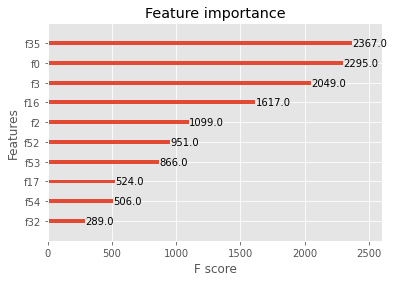

<Figure size 4320x4320 with 0 Axes>

In [179]:
xgboost.plot_importance(model_xgboost,max_num_features=10)
plt.figure(figsize = (60, 60))
plt.show()

## Selecting the final model


-